In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import InputLayer, Dense, Dropout

import matplotlib.pyplot as plt

import math

from time import time

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, recall_score, precision_score
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
df = pd.read_csv("/data/kddcup.data", header=None)

In [4]:
columns = [f.split(":")[0] for f in """
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
""".split("\n") if len(f)>0]

columns.append("Category")
print(columns)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Category']


In [5]:
df.columns = columns

In [6]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Category
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
duration                       int64
protocol_type                  object
service                        object
flag                           object
src_bytes                      int64
dst_bytes                      int64
land                           int64
wrong_fragment                 int64
urgent                         int64
hot                            int64
num_failed_logins              int64
logged_in                      int64
num_compromised                int64
root_shell                     int64
su_attempted                   int64
num_root                       int64
num_file_creations             int64
num_shells                     int64
num_access_files               int64
num_outbound_cmds              int64
is_host_login                  int64
is_guest_login                 int64
count                          int64
srv_count                      in

In [8]:
df.Category.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: Category, dtype: int64

In [27]:
y = np.where(df.Category == "normal.", 0, 1)

In [17]:
X = df.drop(columns=["Category", "flag", "service"])
X.head()

,duration,protocol_type,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,215,45076,0,0,0,0,0,1,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0,tcp,162,4528,0,0,0,0,0,1,...,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
2,0,tcp,236,1228,0,0,0,0,0,1,...,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0
3,0,tcp,233,2032,0,0,0,0,0,1,...,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0
4,0,tcp,239,486,0,0,0,0,0,1,...,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 39 columns):
duration                       int64
protocol_type                  object
src_bytes                      int64
dst_bytes                      int64
land                           int64
wrong_fragment                 int64
urgent                         int64
hot                            int64
num_failed_logins              int64
logged_in                      int64
num_compromised                int64
root_shell                     int64
su_attempted                   int64
num_root                       int64
num_file_creations             int64
num_shells                     int64
num_access_files               int64
num_outbound_cmds              int64
is_host_login                  int64
is_guest_login                 int64
count                          int64
srv_count                      int64
serror_rate                    float64
srv_serror_rate                fl

In [21]:
X = pd.get_dummies(X, drop_first=True)

In [13]:
df.protocol_type.value_counts()

icmp    2833545
tcp     1870598
udp      194288
Name: protocol_type, dtype: int64

In [15]:
df.service.value_counts()

ecr_i          2811660
private        1100831
http            623091
smtp             96554
other            72653
domain_u         57782
ftp_data         40697
eco_i            16338
finger            6891
urp_i             5378
ftp               5214
telnet            4277
ntp_u             3833
auth              3382
pop_3             1981
time              1579
domain            1113
Z39_50            1078
gopher            1077
mtp               1076
ssh               1075
whois             1073
remote_job        1073
rje               1070
imap4             1069
link              1069
ctf               1068
name              1067
supdup            1060
echo              1059
                ...   
vmnet             1053
sql_net           1052
iso_tsap          1052
netbios_dgm       1052
csnet_ns          1051
shell             1051
hostnames         1050
klogin            1050
bgp               1047
login             1045
printer           1045
exec              1045
http_443   

In [16]:
df.flag.value_counts()

SF        3744328
S0         869829
REJ        268874
RSTR         8094
RSTO         5344
SH           1040
S1            532
S2            161
RSTOS0        122
OTH            57
S3             50
Name: flag, dtype: int64

In [20]:
X.isnull().sum(axis = 0)

duration                       0
protocol_type                  0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_s

In [23]:
training_size = int(X.shape[0] * 0.7)
training_size

3428901

In [28]:
X_train, y_train = X[:training_size], y[:training_size]
X_test, y_test = X[training_size:], y[training_size:]

In [29]:
pd.Series(y_train).value_counts()/len(y_train)

1    0.783221
0    0.216779
dtype: float64

In [30]:
pd.Series(y_train).value_counts()/len(y_train)

1    0.783221
0    0.216779
dtype: float64

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
n_x = X_train.shape[1]

tf.set_random_seed(1)
np.random.seed(1)

tensor_board = keras.callbacks.TensorBoard(log_dir="/tmp/tf/logs/%d" % time())

model = keras.Sequential()
model.add(InputLayer((n_x, )))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy
            , metrics=["accuracy"], optimizer="adam")
model.fit(X_train, y_train, batch_size=256
          , validation_data = (X_test, y_test)
          , epochs=1
          , verbose = 1
          , callbacks=[tensor_board])

model.summary()

Train on 3428901 samples, validate on 1469530 samples
Epoch 1/1
3428901/3428901 [==============================] - 33s 10us/step - loss: 0.0447 - acc: 0.9899 - val_loss: 0.0258 - val_acc: 0.9930
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [42]:
y_prob = model.predict(X_test).flatten()

In [47]:
y_test_pred = np.where(y_prob>0.5, 1, 0)

(<matplotlib.figure.Figure at 0x181dab4860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182145e2b0>)

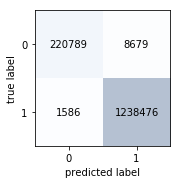

In [48]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

In [50]:
recall_score(y_test, y_test_pred)

0.998721031690351

In [52]:
precision_score(y_test, y_test_pred)

0.9930409612277543

(<matplotlib.figure.Figure at 0x18535edfd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181d83d2b0>)

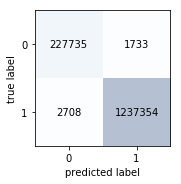

In [53]:
y_test_pred = np.where(y_prob>0.8, 1, 0)
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

(<matplotlib.figure.Figure at 0x182147d630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1846736f98>)

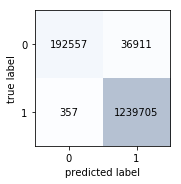

In [54]:
y_test_pred = np.where(y_prob>0.2, 1, 0)
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

In [73]:
n_x = X_train.shape[1]

tf.set_random_seed(1)
np.random.seed(1)

tensor_board = keras.callbacks.TensorBoard(log_dir="/tmp/tf/logs/%d" % time())

model = keras.Sequential()
model.add(InputLayer((n_x, )))
model.add(Dropout(rate=0.5))
model.add(Dense(units=10, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()
model.compile(loss=keras.losses.binary_crossentropy
            , metrics=["accuracy"], optimizer="adam")
model.fit(X_train, y_train, batch_size=256
          , validation_data = (X_test, y_test)
          , epochs=1
          , verbose = 1
          , callbacks=[tensor_board])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                410       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________
Train on 3428901 samples, validate on 1469530 samples
Epoch 1/1
3428901/3428901 [==============================] - 42s 12us/step - loss: 0.0951 

(<matplotlib.figure.Figure at 0x184672b208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181db05dd8>)

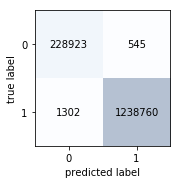

In [57]:
y_test_prob = model.predict(X_test).flatten()
y_test_pred = np.where(y_test_prob>0.5, 1, 0)
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

In [61]:
df = pd.read_csv("/data/creditcard-fraud.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [62]:
df.Class.value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [65]:
df.groupby("Class").Amount.mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

In [63]:
X = df.loc[:, "V1":"V28"].values

In [64]:
y = df.Class.values

-0.160211    77
 0.727706    77
-0.207071    62
 0.959147    60
 0.784393    53
 0.543377    48
 0.683352    45
 0.364539    40
 0.685154    39
 0.808250    36
 0.556451    36
 0.562129    35
 0.791276    30
 0.196360    28
 0.804860    27
 1.054911    27
 0.747692    26
 0.851078    25
 0.385855    25
-0.152624    24
 0.411449    24
 0.483432    24
 0.875786    23
 0.746395    23
 0.714514    21
 0.754420    21
 1.071643    21
 1.090853    21
 0.791559    20
 0.926631    19
             ..
 0.480962     1
-0.017136     1
-0.309678     1
-0.037857     1
-0.682336     1
-0.427800     1
-0.073343     1
-0.438208     1
 0.539568     1
-0.086305     1
-0.580568     1
 0.260311     1
-0.111545     1
 0.149388     1
-0.081699     1
-0.982310     1
 0.185215     1
 0.365207     1
-0.277598     1
 0.606706     1
-0.163725     1
 0.058704     1
-0.070915     1
 0.805684     1
-0.441001     1
 0.294229     1
-0.175237     1
 1.829112     1
 0.027999     1
 0.407707     1
Name: V8, Length: 275663